In [1]:
#!pip install pytictoc
#!pip install pytictoc --upgrade

#!pip install gmpy2
#!pip install mpmath

As of now the Qnk values seem to be saving indexing oddly, (an extra zero at the front) attempt to address this before further steps taking in tuning

In [2]:
from __future__ import division
import numpy as np
import sys
import matplotlib.pylab as plt
import pandas as pd
import open3d as o3d
import scipy
import math
from mpmath import mp
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import interp1d
from pytictoc import TicToc

tt = TicToc() #create instance of class
tt.tic()

#np.seterr(all='raise')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
#load in vessel data frame

try:
    vessel_df = pd.read_pickle ('C:\\Users\\cbnor\\Documents\\Full Body Flow Model Project\\larm.pkl')
except:
    vessel_df = pd.read_pickle ('C:\\Users\\Cassidy.Northway\\RemoteGit\\larm.pkl')
#display(vessel_df)

vessel_df = vessel_df.loc[0:2]
#vessel_df.at[0,'End Condition'] = [1, 2]
vessel_df.at[1,'End Condition'] = 'LW'
vessel_df.at[2,'End Condition'] = 'LW'
#vessel_df.at[4,'End Condition'] = 'LW'
#vessel_df.at[0,'Radius Values'] = [0.37, 0.37]
vessel_df.at[0,'Radius Values'] = [0.37, 0.37]
vessel_df.at[1,'Radius Values'] = [0.177, 0.17]
vessel_df.at[2,'Radius Values'] = [0.177, 0.17]
#vessel_df.at[4,'Radius Values'] = [0.06, 0.056]
vessel_df.at[0, 'lam'] =56.22
vessel_df.at[1, 'lam'] =100
vessel_df.at[2, 'lam'] =99.4
#vessel_df.at[3, 'lam'] =100
#vessel_df.at[4, 'lam'] =100

display(vessel_df)

,Name,lam,Radius Values,End Condition,k Array
0,left_arm_artery_0,56.22,"[0.37, 0.37]","[1, 2]","[20000000.0, -22.5, 865000.0]"
1,left_arm_artery_1,100,"[0.177, 0.17]",LW,"[20000000.0, -22.5, 865000.0]"
2,arteries_larm10_0,99.4,"[0.177, 0.17]",LW,"[20000000.0, -22.5, 865000.0]"


In [4]:
# %load artery.py

from __future__ import division

import numpy as np
import sys
import matplotlib.pylab as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import interp1d


class Artery(object):
    """
    Class representing an artery.
    
    :param pos: Artery ID
    :param Ru: Upstream radius
    :param Rd: Downstream radius
    :param lam: Length-to-radius (upstream) ratio 
    :param k: Iterable containing elasticity parameters k1, k2, k3
    :param Re: Reynold's number
    :param p0: Zero transmural pressure
    :param alpha: radii ratio for structured tree
    :param beta: radii ratio for structured tree
    :param r_min: minimum radius 
    :param Z_term: terminal impedance
    """
        
        
    def __init__(self, pos, Ru, Rd, lam, k, Re, p0, alpha, beta, r_min, Z_term):
        """
        Artery constructor.
        """
        self._pos = pos
        self._Ru = Ru
        self._Rd = Rd
        self._L = Ru*lam
        self._k = k
        self._Re = Re
        self._p0 = p0
        self._alpha = alpha
        self._beta = beta
        self._r_min = r_min
        self._Z_term = Z_term
        
    def impedance_weights(self, r_root,dt, T,tc):
        acc = 1e-10 #numerical accuracy of impedance fcn
        N = math.ceil(1/dt)
        eta = acc**(1/(2*N))
        empty_table = {}
        m = np.linspace(0,2*np.pi,(2*N)+1) #actual [0:2N-1] the size of 2N
        zeta = eta * np.exp(1j*m)
        Xi = 0.5*(zeta**2) - (2*zeta) + (3/2)
        [Z_impedance, table] = Artery.impedance(self, Xi/dt, r_root, 0, 0, empty_table)
        print('Progress: Impedance calculated')
        z_n = np.zeros(int(T/dt)*tc, dtype = np.complex_)
        weighting = np.concatenate (([1], 2*np.ones(2*N-1),[1]))/ (4 * N) 
        for n in range(0,N+1): # actual range [0,N]
            z_n[n] = ((1/(eta**n))*np.sum(weighting*Z_impedance * np.exp(-1j*n*m)))
        print('Progress: z[n] values calculated')
        z_n = np.real(z_n)
        
        #plt.plot(z_n,'.')
        #print(z_n[0:10])
        #plt.show()

        return z_n
    
    def impedance(self, s, r_root, N_alpha, N_beta, table):
        ZL = np.zeros(np.size(s), dtype = np.complex_)
        r_0 = r_root * (alpha ** N_alpha) *(beta ** N_beta)
        if r_0 < r_min:
        
            ZL[:] = 0
        else:
            try:
                ZD1 = table[N_alpha + 1 , N_beta]
            except:
                [ZD1, table] = Artery.impedance( self, s,r_root,N_alpha+1,N_beta,table)
            try:
                ZD2 = table[N_alpha, N_beta +1,:]
            except:
                [ZD2, table] = Artery.impedance(self, s, r_root, N_alpha, N_beta + 1, table)
            
            
       
            ZL = (ZD1 * ZD2) / (ZD1 + ZD2)#ZL needs to be an array of values over the s_range size
        
        Z0 = Artery.singleVesselImpedance(ZL,s,r_0)
        table[N_alpha,N_beta] = Z0
        return [Z0, table]
                     
    def singleVesselImpedance(ZL, s_range, r_0):
        gamma = 2 #velocity profile
        mu = 0.048 #blood viscosity
        lambd = 50 #length/radius ratio
        rho = 1.055 #blood density
        L = r_0 *lambd
        A0 = np.pi * (r_0 ** 2)
        Ehr = (2e7 *np.exp( -22.5*r_0) + 8.65e5) #Youngs Modulus * vessel thickness/radius
        C = (3/2) *(A0)/(Ehr)#complaince
        delta = (2 * mu*(gamma +2))/ (rho *r_0**2)
        i = 0
        Z0 = np.zeros(np.size(s_range), dtype = np.complex_)
        for s in s_range:
            if s == 0:
                Z0[i] = ZL[i] + (2*(gamma +2)*mu* lambd) / (np.pi * r_0**3)
                print('s=0')
            else:
                d_s = (A0/(C*rho*s*(s+delta)))**(0.5)
                num = ZL[i] +np.tanh(L/d_s)/(s*d_s*C)
                denom = s*d_s*C*ZL[i]*np.tanh(L/d_s) + 1
                Z0[i] = num/denom
            i = i + 1
        return Z0
                           
    def initial_conditions(self, u0, dt, dataframe, T, tc):
        """
        Initialises solution arrays with initial conditions.
        Checks if artery.mesh(dx) has been called first.
        
        :param u0: Initial conditions for solution
        :param ntr: Number of solution time steps to be stored
        :raises: AttributeError
        """
        if not hasattr(self, '_nx'):
            raise AttributeError('Artery not meshed. Execute mesh(self, dx) \
before setting initial conditions.')
        self.U0[0,:] = self.A0.copy()
        self.U0[1,:].fill(u0)
        self.Uold = self.U0.copy()
        
        if  dataframe.at[self.pos,'End Condition'] == 'LW':
            zn = Artery.impedance_weights(self, self.Rd, dt, T, tc)
            self._zn = zn
            self._Qnk = np.zeros(int(T/dt)*tc)
        else:
            self._zn = 0
            self._Qnk = 0
           
    def mesh(self, dx, ntr):
        """
        Meshes an artery using spatial step size dx.
        
        :param dx: Spatial step size
        """
        self._dx = dx
        self._nx = int(self.L/dx)+1
        if self.nx-1 != self.L/dx:
            self.L = dx * (self.nx-1)
        X = np.linspace(0.0, self.L, self.nx)
        R = self.Ru * np.power((self.Rd/self.Ru), X/self.L)
        self._A0 = np.power(R, 2)*np.pi
        self._f = 4/3 * (self.k[0] * np.exp(self.k[1]*R) + self.k[2])
        self._df = 4/3 * self.k[0] * self.k[1] * np.exp(self.k[1]*R)
        self._xgrad = (self.Ru * np.log(self.Rd/self.Ru) * np.power((self.Rd/self.Ru), X/self.L))/self.L
        self.U = np.zeros((2, ntr, self.nx))
        self.P = np.zeros((ntr, self.nx))
        self.U0 = np.zeros((2, self.nx))
        self.Uold = np.zeros((2, self.nx))
        
    def boundary_layer_thickness(self, nu, T):
        """
        Calculates the boundary layer thickness of the artery according to
        
        delta = sqrt(nu*T/2*pi).
        
        :param nu: Viscosity of blood
        :param T: Length of one periodic cycle.
        """
        self._delta = np.sqrt(nu*T/(2*np.pi))
        
        
    def p(self, a, **kwargs):
        """
        Calculates pressure according to the state equation.
        
        :param a: Area
        :param \**kwargs: See below
        :returns: Pressure 

        :Keyword Arguments:
            * *j* (``int``) -- Index variable
        """
        if 'j' in kwargs:
            j = kwargs['j']
            p = self.f[j] * (1 - np.sqrt(self.A0[j]/a)) + self.p0
        else:
            p = self.f * (1 - np.sqrt(self.A0/a)) + self.p0
        return p
        

    def wave_speed(self, a):
        """
        Calculates the wave speed (required to check CFL condition).
        
        :param a: Area
        :returns: Wave speed
        """
        return -np.sqrt(0.5 * self.f * np.sqrt(self.A0/a))
        
        
    def F(self, U, **kwargs):
        """
        Calculates the flux vector.
        
        :param U: Previous solution
        :param \**kwargs: See below
        :returns: Flux for current solution
        :raises: IndexError
        
        :Keyword Arguments:
            * *j* (``int``) -- Index variable (start)
            * *k* (``int``) -- Index variable (end)
        """
        a, q = U
        out = np.empty_like(U)
        out[0] = q
        if 'j' in kwargs:
            j = kwargs['j']
            a0 = self.A0[j]
            f = self.f[j]
        elif 'k' in kwargs:
            j = kwargs['j']
            k = kwargs['k']
            a0 = self.A0[j:k]
            f = self.f[j:k]
        else:
            raise IndexError("Required to supply at least one index in function F.")
            
        
        out[1] = np.power(q, 2)/a + f * np.sqrt(a0*a)
       
      
        return out
        
        
    def S(self, U, **kwargs):
        """
        Calculates the flux vector.
        
        :param U: Previous solution
        :param \**kwargs: See below
        :returns: Flux for current solution
        :raises: IndexError
        
        :Keyword Arguments:
            * *j* (``int``) -- Index variable (start)
            * *k* (``int``) -- Index variable (end)
        """
        a, q = U
        out = np.zeros(U.shape)
        if 'j' in kwargs:
            j = kwargs['j']
            a0 = self.A0[j]
            xgrad = self.xgrad[j]
            f = self.f[j]
            df = self.df[j]
        elif 'k' in kwargs:
            j = kwargs['j']
            k = kwargs['k']
            a0 = self.A0[j:k]
            xgrad = self.xgrad[j:k]
            f = self.f[j:k]
            df = self.df[j:k]
        else:
            raise IndexError("Required to supply at least one index in function S.")
        R = np.sqrt(a0/np.pi)
        
        out[1] = -(2*np.pi*R/(self.Re*self.delta)) * (q/a) +\
                (2*np.sqrt(a) * (np.sqrt(np.pi)*f +\
                np.sqrt(a0)*df) - a*df) * xgrad

       
        return out
        
        
    def dBdx(self, l, xi):
        """
        Calculates dB/dx (see [1]).
        
        [1] M. S. Olufsen. Modeling of the Arterial System with Reference to an Anesthesia Simulator. PhD thesis, University of Roskilde, Denmark, 1998.
        
        :param l: Position, either M+1/2 or -1/2.
        :param xi: Area.
        :returns: Solution to dB/dx
        """
        if l > self.L:
            x_0 = self.L-self.dx
            x_1 = self.L
            f_l = extrapolate(l, [x_0, x_1], [self.f[-2], self.f[-1]])  
            A0_l = extrapolate(l, [x_0, x_1], [self.A0[-2], self.A0[-1]])  
            df_l = extrapolate(l, [x_0, x_1], [self.df[-2], self.df[-1]])
            xgrad_l = extrapolate(l, [x_0, x_1],
                                        [self.xgrad[-2], self.xgrad[-1]])
        elif l < 0.0:
            x_0 = self.dx
            x_1 = 0.0
            f_l = extrapolate(l, [x_0, x_1], [self.f[1], self.f[0]])  
            A0_l = extrapolate(l, [x_0, x_1], [self.A0[1], self.A0[0]]) 
            df_l = extrapolate(l, [x_0, x_1], [self.df[1], self.df[0]])
            xgrad_l = extrapolate(l, [x_0, x_1],
                                        [self.xgrad[1], self.xgrad[0]])
        elif l == self.L:
            f_l = self.f[-1]
            A0_l = self.A0[-1]
            df_l = self.df[-1]
            xgrad_l = self.xgrad[-1]
        else:
            f_l = self.f[0]
            A0_l = self.A0[0]
            df_l = self.df[0]
            xgrad_l = self.xgrad[0]
        return (2*np.sqrt(xi) * (np.sqrt(np.pi)*f_l + np.sqrt(A0_l)*df_l) -\
                    xi*df_l) * xgrad_l
        
        
    def dBdxi(self, l, xi):
        """
        Calculates dB/dx_i (see [1]).
        
        [1] M. S. Olufsen. Modeling of the Arterial System with Reference to an Anesthesia Simulator. PhD thesis, University of Roskilde, Denmark, 1998.
        
        :param l: Position, either M+1/2 or -1/2.
        :param xi: Area.
        :returns: Solution to dB/dx_i
        """
        if l > self.L:
            x_0 = self.L-self.dx
            x_1 = self.L
            f_l = extrapolate(l, [x_0, x_1], [self.f[-2], self.f[-1]])  
            A0_l = extrapolate(l, [x_0, x_1], [self.A0[-2], self.A0[-1]])  
        elif l < 0.0:
            x_0 = self.dx
            x_1 = 0.0
            f_l = extrapolate(l, [x_0, x_1], [self.f[1], self.f[0]])  
            A0_l = extrapolate(l, [x_0, x_1], [self.A0[1], self.A0[0]]) 
        elif l == self.L:
            f_l = self.f[-1]
            A0_l = self.A0[-1]
        else:
            f_l = self.f[0]
            A0_l = self.A0[0]
        return f_l/2 * np.sqrt(A0_l/xi)
        
        
    def dBdxdxi(self, l, xi):
        """
        Calculates d^2B/dxdx_i (see [1]).
        
        [1] M. S. Olufsen. Modeling of the Arterial System with Reference to an Anesthesia Simulator. PhD thesis, University of Roskilde, Denmark, 1998.
        
        :param l: Position, either M+1/2 or -1/2.
        :param xi: Area.
        :returns: Solution to d^2B/dxdx_i
        """
        if l > self.L:
            x_0 = self.L-self.dx
            x_1 = self.L
            f_l = extrapolate(l, [x_0, x_1], [self.f[-2], self.f[-1]])   
            df_l = extrapolate(l, [x_0, x_1], [self.df[-2], self.df[-1]])   
            A0_l = extrapolate(l, [x_0, x_1], [self.A0[-2], self.A0[-1]])  
            xgrad_l = extrapolate(l, [x_0, x_1],
                                        [self.xgrad[-2], self.xgrad[-1]])
        elif l < 0.0:
            x_0 = self.dx
            x_1 = 0.0
            f_l = extrapolate(l, [x_0, x_1], [self.f[1], self.f[0]])   
            df_l = extrapolate(l, [x_0, x_1], [self.df[1], self.df[0]])   
            A0_l = extrapolate(l, [x_0, x_1], [self.A0[1], self.A0[0]])  
            xgrad_l = extrapolate(l, [x_0, x_1],
                                        [self.xgrad[1], self.xgrad[0]])
        elif l == self.L:
            f_l = self.f[-1]   
            df_l = self.df[-1]
            A0_l = self.A0[-1]
            xgrad_l = self.xgrad[-1]
        else:
            f_l = self.f[0]   
            df_l = self.df[0]
            A0_l = self.A0[0]
            xgrad_l = self.xgrad[0]
     
        return (1/(2*np.sqrt(xi)) * (f_l*np.sqrt(np.pi) +\
                                    df_l*np.sqrt(A0_l)) - df_l) * xgrad_l
        
                                    
                                    
    def dFdxi2(self, l, xi1, xi2):
        """
        Calculates dF/dx_2 (see [1]).
        
        [1] M. S. Olufsen. Modeling of the Arterial System with Reference to an Anesthesia Simulator. PhD thesis, University of Roskilde, Denmark, 1998.
        
        :param l: Position, either M+1/2 or -1/2.
        :param xi: Area.
        :returns: Solution to dF/dx_2
        """
        if l > self.L:
            x_0 = self.L-self.dx
            x_1 = self.L
            R0_l = extrapolate(l, [x_0, x_1], 
                    [np.sqrt(self.A0[-2]/np.pi), np.sqrt(self.A0[-1]/np.pi)])
        elif l < 0.0:
            x_0 = self.dx
            x_1 = 0.0
            R0_l = extrapolate(l, [x_0, x_1], 
                    [np.sqrt(self.A0[1]/np.pi), np.sqrt(self.A0[0]/np.pi)])
        elif l == self.L:
            R0_l = np.sqrt(self.A0[-1]/np.pi)
        else:
            R0_l = np.sqrt(self.A0[0]/np.pi)
        return 2*np.pi*R0_l/(self.delta*self.Re) * xi1/(xi2*xi2)
        
        
    def dFdxi1(self, l, xi2):
        """
        Calculates dF/dx_1 (see [1]).
        
        [1] M. S. Olufsen. Modeling of the Arterial System with Reference to an Anesthesia Simulator. PhD thesis, University of Roskilde, Denmark, 1998.
        
        :param l: Position, either M+1/2 or -1/2.
        :param xi: Area.
        :returns: Solution to dF/dx_1
        """
        if l > self.L:
            x_0 = self.L-self.dx
            x_1 = self.L
            R0_l = extrapolate(l, [x_0, x_1], 
                    [np.sqrt(self.A0[-2]/np.pi), np.sqrt(self.A0[-1]/np.pi)])
        elif l < 0.0:
            x_0 = self.dx
            x_1 = 0.0
            R0_l = extrapolate(l, [x_0, x_1], 
                    [np.sqrt(self.A0[1]/np.pi), np.sqrt(self.A0[0]/np.pi)])
        elif l == self.L:
            R0_l = np.sqrt(self.A0[-1]/np.pi)
        else:
            R0_l = np.sqrt(self.A0[0]/np.pi)
        return -2*np.pi*R0_l/(self.delta*self.Re) * 1/xi2
        
        
    def dpdx(self, l, xi):
        """
        Calculates dp/dx (see [1]).
        
        [1] M. S. Olufsen. Modeling of the Arterial System with Reference to an Anesthesia Simulator. PhD thesis, University of Roskilde, Denmark, 1998.
        
        :param l: Position, either M+1/2 or -1/2.
        :param xi: Area.
        :returns: Solution to dp/dx
        """
        if l > self.L:
            x_0 = self.L-self.dx
            x_1 = self.L
            f_l = extrapolate(l, [x_0, x_1], [self.f[-2], self.f[-1]])   
            A0_l = extrapolate(l, [x_0, x_1], [self.A0[-2], self.A0[-1]])  
        elif l < 0.0:
            x_0 = self.dx
            x_1 = 0.0
            f_l = extrapolate(l, [x_0, x_1], [self.f[1], self.f[0]])   
            A0_l = extrapolate(l, [x_0, x_1], [self.A0[1], self.A0[0]])
        elif l == self.L:
            f_l = self.f[-1]   
            A0_l = self.A0[-1]
        else:
            f_l = self.f[0]   
            A0_l = self.A0[0]
        return f_l/2 * np.sqrt(A0_l/xi**3)
        
        
    def solve(self, lw, U_in, U_out, save, i):
        """
        Solver calling the LaxWendroff solver and storing the new solution in U0.lw
        Stores new solution in output array U if save is True.
        
        :param lw: LaxWendroff object
        :param U_in: Inlet boundary condition
        :param U_out: Outlet boundary condition
        :param save: True if current time step is to be saved
        :param i: Current time step
        """
        # solve for current timestep
        U1 = lw.solve(self.U0, U_in, U_out, self.F, self.S)
        if save:
            self.P[i,:] = self.p(self.U0[0,:])
            np.copyto(self.U[:,i,:], self.U0)
        np.copyto(self.Uold,self.U0)
        np.copyto(self.U0, U1)
        

    def dump_results(self, suffix, data_dir):
        """
        Outputs solutions U, P to csv files
        
        :param suffix: Simulation identifier
        :param data_dir: Directory data files are stored in
        """
        np.savetxt("%s/%s/u%d_%s.csv" % (data_dir, suffix, self.pos, suffix),
                   self.U[1,:,:], delimiter=',')
        np.savetxt("%s/%s/a%d_%s.csv" % (data_dir, suffix, self.pos, suffix),
                   self.U[0,:,:], delimiter=',')  
        np.savetxt("%s/%s/p%d_%s.csv" % (data_dir, suffix, self.pos, suffix),
                   self.P, delimiter=',') 
                   
                   
    @property
    def L(self):
        """
        Artery length
        """
        return self._L

    @L.setter
    def L(self, value):
        self._L = value
        
    @property
    def nx(self):
        """
        Number of spatial steps
        """
        return self._nx
        
    @property
    def Ru(self):
        """
        Upstream radius
        """
        return self._Ru
        
    @property
    def Rd(self):
        """
        Downstream radius
        """
        return self._Rd
        
    @property
    def k(self):
        """
        Elasticity parameters for relation Eh/r = k1 * exp(k2*r) + k3
        """
        return self._k
        
    @property
    def A0(self):
        """
        Area at rest
        """
        return self._A0
        
    @property
    def dx(self):
        """
        Spatial step size
        """
        return self._dx
    
    @property
    def pos(self):
        """
        Position in ArteryNetwork
        """
        return self._pos
        
    @property
    def f(self):
        """
        f = 4/3 Eh/r
        """
        return self._f
        
    @property
    def xgrad(self):
        """
        dr/dx
        """
        return self._xgrad
        
    @property
    def df(self):
        """
        df/dr
        """        
        return self._df

    @property
    def Re(self):
        """
        Reynold's number
        """
        return self._Re
        
    @property
    def delta(self):
        """
        Boundary layer thickness
        """
        return self._delta

    @property
    def p0(self):
        """
        Zero transmural pressure
        """
        return self._p0
    
    @property
    def alpha(self):
        """
        Radii ratio for structured tree calculations
        """
        return self._alpha
    
    @property
    def beta(self):
        """
        Radii ratio for structured tree calculations
        """
        return self._beta                     
                     
    @property
    def r_min(self):
        """
        Minimum radius at which structured trees terminate
        """
        return self._r_min
                     
                     
    @property
    def Z_term(self):
        """
        Terminal impedance of structured trees
        """
        return self._Z_term 
                     
    @property
    def zn(self):
        """
        Impedance weights 
        """
        return self._zn
    
    @property
    def Qnk(self):
        """
        Stored flow values for structured tree values
        """
        return self._Qnk
    #def Lrr

In [5]:
# %load artery_network.py

from __future__ import division
import numpy as np

from scipy import linalg



from os import makedirs
from os.path import exists

import sys



class ArteryNetwork(object):
    """
    Class representing a network of arteries.
    
    :param Ru: Iterable containing upstream radii.
    :param Rd: Iterable containing downstream radii.
    :param lam: Iterable containing length-to-radius ratios.
    :param k: Iterable containing elasticity parameters.
    :param rho: Density of blood.
    :param nu: Viscosity of blood.
    :param p0: Zero transmural pressure.
    :param depth: Depth of the arterial tree, e. g. 1 for one artery, 2 for three arteries. ##I WANT TO EDIT THIS CONCEPT OUT
    :param ntr: Number of time steps in output.
    :param Re: Reynolds number.
    :param dataframe: Dataframe containing the artery information
    :param alpha: Radii ratio for structured tree
    :param beta: Radii ratio for structured tree
    :param r_min: Minimum radii
    :param Z_term: Terminal impedance
    """
    
    
    def __init__(self, rho, nu, p0, ntr, Re, k, dataframe, Z_term, alpha, beta, r_min,):
        """
        ArteryNetwork constructor.
        """
        #MODIFIED TO: NOT USE DEPTH TO create all the arteries but create arteries for all arteries in dataframe    
        self._t = 0.0
        self._ntr = ntr
        self._progress = 0
        self._rho = rho
        self._nu = nu
        self._p0 = p0
        self._k = k
        self._dataframe = dataframe 
        self._arteries = [0] * len(dataframe)
        self.setup_arteries(Re, p0, k,alpha, beta, r_min, Z_term)     
        
    def setup_arteries(self, Re, p0, k, alpha, beta, r_min, Z_term):
        """
        Creates Artery objects.
        
        :param Ru: Iterable containing upstream radii.
        :param Rd: Iterable containing downstream radii.
        :param lam: Iterable containing length-to-radius ratios.
        :param k: Iterable containing elasticity parameters.
        :param Re: Reynolds number.
        :param Z_term: 
        """
        
        #Creates all artery objects 
        for i in range(0,len(dataframe)):
            Ru = dataframe.at[i,'Radius Values'][0] 
            Rd = dataframe.at[i,'Radius Values'][1]
            lam = dataframe.at[i,'lam']
            #k = dataframe.at[i,'k Array']
            self.arteries[i] = Artery(i, Ru, Rd, lam, k, Re, p0, alpha, beta, r_min, Z_term)

                   
    def initial_conditions(self, u0, dataframe):
        """
        Invokes initial_conditions(u0) on each artery in the network.
        
        :param u0: Initial condition for U_1.
        """
        for artery in self.arteries:
            artery.initial_conditions(u0, self.dt, dataframe, self.T, self.tc)
            
            
            
    def mesh(self, dx):
        """
        Invokes mesh(nx) on each artery in the network
        
        :param dx: Spatial step size
        """
        for artery in self.arteries:
            artery.mesh(dx, self.ntr)
            
            
    def set_time(self, dt, T, tc=1):
        """
        Sets timing parameters for the artery network and invokes
        boundary_layer_thickness(T) in each artery.
        
        :param dt: Time step size.
        :param T: Length of one periodic cycle.
        :param tc: Number of cycles.
        """
        self._dt = dt
        self._tf = T*tc
        self._dtr = self.tf/self.ntr
        self._T = T
        self._tc = tc
        for artery in self.arteries:
            artery.boundary_layer_thickness(self.nu, T)
            
            
    def timestep(self):
        """
        Increases time by dt.
        """
        self._t += self.dt
            
    
    @staticmethod        
    def inlet_bc(artery, q_in, in_t, dt):
        """
        Calculates inlet boundary condition.
        
        :param artery: Inlet artery.
        :param q_in: Function containing inlet condition U_1(t).
        :param in_t: Current time.
        :param dt: Time step size.
        :returns: Array containing solution U at the inlet. 
        """
        q_0_np = q_in(in_t-dt/2) # q_0_n+1/2
        q_0_n1 = q_in(in_t) # q_0_n+1
        U_0_n = artery.U0[:,0] # U_0_n
        U_1_n = artery.U0[:,1]
        U_12_np = (U_1_n+U_0_n)/2 -\
                    dt*(artery.F(U_1_n, j=1)-artery.F(U_0_n, j=0))/(2*artery.dx) +\
                    dt*(artery.S(U_1_n, j=1)+artery.S(U_0_n, j=0))/4 # U_1/2_n+1/2
        a_0_n1 = U_0_n[0] - 2*dt*(U_12_np[1] - q_0_np)/artery.dx
        return np.array([a_0_n1, q_0_n1])
     
    
    @staticmethod
    def outlet_wk3(artery, dt, R1, R2, Ct):
        """
        Function calculating the three-element Windkessel outlet boundary
        condition.
        
        :param artery: Artery object of outlet artery
        :param dt: time step size
        :param R1: first resistance element
        :param R2: second resistance element
        :param Ct: compliance element
        :returns: Numpy array containing the outlet area and flux
        """
        theta = dt/artery.dx
        gamma = dt/2
        U0_1 = artery.U0[:,-1] # m = M
        U0_2 = artery.U0[:,-2] # m = M-1
        U0_3 = artery.U0[:,-3] # m = M-2
        a_n, q_n = U0_1
        p_new = p_n = artery.p(a_n, j=-1) # initial guess for p_out
        U_np_mp = (U0_1 + U0_2)/2 +\
                gamma * (-(artery.F(U0_1, j=-1) - artery.F(U0_2, j=-2))/artery.dx +\
                        (artery.S(U0_1, j=-1) + artery.S(U0_2, j=-2))/2)
        U_np_mm = (U0_2 + U0_3)/2 +\
                gamma * (-(artery.F(U0_2, j=-2) - artery.F(U0_3, j=-3))/artery.dx +\
                        (artery.S(U0_2, j=-2) + artery.S(U0_3, j=-3))/2)
        U_mm = U0_2 - theta*(artery.F(U_np_mp, j=-2) - artery.F(U_np_mm, j=-2)) +\
                gamma*(artery.S(U_np_mp, j=-2) + artery.S(U_np_mm, j=-2))
        k = 0
        X = dt/(R1*R2*Ct)
        while k < 1000:
            p_old = p_new
            q_out = X*p_n - X*(R1+R2)*q_n + (p_old-p_n)/R1 + q_n
            a_out = a_n - theta * (q_out - U_mm[1])
            p_new = artery.p(a_out, j=-1)
            if abs(p_old - p_new) < 1e-7:
                break
            k += 1
        return np.array([a_out, q_out])
    
    
    @staticmethod
    def outlet_p(artery, dt, P):
        """
        Function calculating cross-sectional area and flow rate for a fixed
        pressure outlet boundary condition.
        
        :param artery: Artery object of outlet artery
        :param dt: time step size
        :param P: outlet pressure
        """
        theta = dt/artery.dx
        gamma = dt/2
        U0_1 = artery.U0[:,-1]
        U0_2 = artery.U0[:,-2]
        a_n, q_n = U0_1
        p_out = P # initial guess for p_out
        a_out = (artery.A0[-1]*artery.f[-1]**2) / (artery.f[-1] - p_out)**2
        U_np_mm = (U0_1 + U0_2)/2 -\
                theta*(artery.F(U0_1, j=-1) - artery.F(U0_2, j=-2))/2 +\
                gamma*(artery.S(U0_1, j=-1) + artery.S(U0_2, j=-2))/2
        a_np_mp = 2*a_out - U_np_mm[0]
        q_np_mp = (a_n - a_out)/theta + U_np_mm[1]
        U_np_mp = np.array([a_np_mp, q_np_mp])
        U_out = U0_1 - theta*(artery.F(U_np_mp, j=-1) - artery.F(U_np_mm, j=-1)) +\
                gamma*(artery.S(U_np_mp, j=-1) + artery.S(U_np_mm, j=-1))
        return U_out
    

    @staticmethod
    def outlet_st(artery, dt, t):
        """
        :param t: Current time step, within the period, 0<=t<=T
        """
        k_array = np.arange(0,t+dt,dt) #actual range [0,t]
        n_value = np.size(k_array)
        zk_array = artery.zn[0:n_value+1]
        Qnk_array = np.flip(artery.Qnk[0:n_value+1])
        #Need to have stored Q values for every time step up to this point
        #for k = 0 to n (n=current number of time steps)
        p_out = np.sum(zk_array*Qnk_array)  #pressure at nth time step with constant time steps dt          
        #Here I take the outlet_p code from above
        theta = dt/artery.dx
        gamma = dt/2
        U0_1 = artery.U0[:,-1]
        U0_2 = artery.U0[:,-2]
        a_n, q_n = U0_1
        a_out = (artery.A0[-1]*artery.f[-1]**2) / (artery.f[-1] - p_out)**2
        U_np_mm = (U0_1 + U0_2)/2 -\
                theta*(artery.F(U0_1, j=-1) - artery.F(U0_2, j=-2))/2 +\
                gamma*(artery.S(U0_1, j=-1) + artery.S(U0_2, j=-2))/2
        a_np_mp = 2*a_out - U_np_mm[0]
        q_np_mp = (a_n - a_out)/theta + U_np_mm[1]
        U_np_mp = np.array([a_np_mp, q_np_mp])
        U_out = U0_1 - theta*(artery.F(U_np_mp, j=-1) - artery.F(U_np_mm, j=-1)) +\
                gamma*(artery.S(U_np_mp, j=-1) + artery.S(U_np_mm, j=-1))
        return U_out
         #Do we want to reset k at t>T or do we want to have total t regardless of number of T
    @staticmethod
    def jacobian(x, parent, d1, d2, theta, gamma):
        """
        Calculates the Jacobian for using Newton's method to solve bifurcation inlet and outlet boundary conditions [1].
        
        [1] [1] M. S. Olufsen. Modeling of the Arterial System with Reference to an Anesthesia Simulator. PhD thesis, University of Roskilde, Denmark, 1998.
        
        :param x: Solution of the system of equations.
        :param parent: Artery object of the parent vessel.
        :param d1: Artery object of the first daughter vessel.
        :param d2: Artery object of the second daughter vessel.
        :param theta: dt/dx
        :param gamma: dt/2
        :returns: The Jacobian for Newton's method.
        """
        M12 = parent.L + parent.dx/2
        D1_12 = -d1.dx/2
        D2_12 = -d2.dx/2
        zeta7 = -parent.dpdx(parent.L, x[10])
        zeta10 = -parent.dpdx(parent.L, x[9])
        Dfr = np.zeros((18, 18)) # Jacobian
        Dfr[0,0] = Dfr[1,3] = Dfr[2,6] = Dfr[3,9] = Dfr[4,12] = Dfr[5,15] = -1
        Dfr[6,1] = Dfr[7,4] = Dfr[8,7] = Dfr[9,10] = Dfr[10,13] = Dfr[11,16] = -1
        Dfr[12,1] = Dfr[13,0] = -1
        Dfr[6,2] = Dfr[7,5] = Dfr[8,8] = Dfr[9,11] = Dfr[10,14] = Dfr[11,17] = 0.5
        Dfr[12,4] = Dfr[12,7] = Dfr[13,3] = Dfr[13,6] = 1.0
        Dfr[3,2] = -theta
        Dfr[4,5] = Dfr[5,8] = theta
        Dfr[0,2] = -2*theta*x[2]/x[11] + gamma*parent.dFdxi1(M12, x[11])
        Dfr[0,11] = theta * (x[2]**2/x[11]**2 - parent.dBdxi(M12,x[11])) +\
                    gamma * (parent.dFdxi2(M12, x[2], x[11]) +\
                            parent.dBdxdxi(M12, x[11]))
        Dfr[1,5] = 2*theta*x[5]/x[14] + gamma*d1.dFdxi1(D1_12, x[14])
        Dfr[1,14] = theta * (-x[5]**2/x[14]**2 + d1.dBdxi(D1_12,x[14])) +\
                    gamma * (d1.dFdxi2(D1_12, x[5], x[14]) +\
                            d1.dBdxdxi(D1_12, x[14]))
       
        Dfr[2,8] = 2*theta*x[8]/x[17] + gamma*d2.dFdxi1(D2_12, x[17])
        
        Dfr[2,17] = theta * ((-x[8]**2/x[17]**2 + 0) +\
                    gamma * (0) +\
                            d2.dBdxdxi(D2_12, x[17]))
       
        Dfr[14,10] = zeta7
        Dfr[14,13] = d1.dpdx(0.0, x[13])
        Dfr[15,10] = zeta7
        Dfr[15,16] = d2.dpdx(0.0, x[16])
        Dfr[16,9] = zeta10
        Dfr[16,12] = d1.dpdx(0.0, x[12])
        Dfr[17,9] = zeta10
        Dfr[17,15] = d2.dpdx(0.0, x[15])

        return Dfr
        

    @staticmethod
    def residuals(x, parent, d1, d2, theta, gamma, U_p_np, U_d1_np, U_d2_np):
        """
        Calculates the residual equations for using Newton's method to solve bifurcation inlet and outlet boundary conditions [1].
        
        [1] M. S. Olufsen. Modeling of the Arterial System with Reference to an Anesthesia Simulator. PhD thesis, University of Roskilde, Denmark, 1998.
        [2] R. J. LeVeque. Numerical Methods for Conservation Laws. Birkhauser Verlag, Basel, Switzerland, 2nd edition, 1992.
        
        :param x: Solution of the system of equations.
        :param parent: Artery object of the parent vessel.
        :param d1: Artery object of the first daughter vessel.
        :param d2: Artery object of the second daughter vessel.
        :param theta: dt/dx
        :param gamma: dt/2
        :param U_p_np: U_(M-1/2)^(n+1/2) [2]
        :param U_p_np: U_(M-1/2)^(n+1/2) [2]
        :returns: The residual equations for Newton's method.
        """
        f_p_mp = extrapolate(parent.L+parent.dx/2,
                [parent.L-parent.dx, parent.L], [parent.f[-2], parent.f[-1]])
        f_d1_mp = extrapolate(-d1.dx/2, [d1.dx, 0.0],
                                    [d1.f[1], d1.f[0]])
        f_d2_mp = extrapolate(-d2.dx/2, [d2.dx, 0.0],
                                    [d2.f[1], d2.f[0]])
        A0_p_mp = extrapolate(parent.L+parent.dx/2,
                [parent.L-parent.dx, parent.L], [parent.A0[-2], parent.A0[-1]])
        A0_d1_mp = extrapolate(-d1.dx/2, [d1.dx, 0.0],
                                     [d1.A0[1], d1.A0[0]])
        A0_d2_mp = extrapolate(-d2.dx/2, [d2.dx, 0.0],
                                     [d2.A0[1], d2.A0[0]])
        R0_p_mp = np.sqrt(A0_p_mp/np.pi)
        R0_d1_mp = np.sqrt(A0_d1_mp/np.pi)
        R0_d2_mp = np.sqrt(A0_d2_mp/np.pi)
        B_p_mp = f_p_mp * np.sqrt(x[11]*A0_p_mp)
        B_d1_mp = f_d1_mp * np.sqrt(x[14]*A0_d1_mp)
        B_d2_mp = f_d2_mp * np.sqrt(x[17]*A0_d2_mp)
        k1 = parent.U0[1,-1] + theta * (parent.F(U_p_np, j=-1)[1]) +\
                gamma * (parent.S(U_p_np, j=-1)[1])
        k2 = d1.U0[1,0] - theta * (d1.F(U_d1_np, j=0)[1]) +\
                gamma * (d1.S(U_d1_np, j=0)[1])
        k3 = d2.U0[1,0] - theta * (d2.F(U_d2_np, j=0)[1]) +\
                gamma * (d2.S(U_d2_np, j=0)[1])
        k4 = parent.U0[0,-1] + theta*parent.F(U_p_np, j=-1)[0]
        k5 = d1.U0[0,0] - theta*d1.F(U_d1_np, j=0)[0]
        k6 = d2.U0[0,0] - theta*d2.F(U_d2_np, j=0)[0]
        k7 = U_p_np[1]/2
        k8 = U_d1_np[1]/2
        k9 = U_d2_np[1]/2
        k10 = U_p_np[0]/2
        k11 = U_d1_np[0]/2
        k12 = U_d2_np[0]/2
        k15a = -parent.f[-1] + d1.f[0]
        k15b = d1.f[0] * np.sqrt(d1.A0[0])
        k16a = -parent.f[-1] + d2.f[0]
        k16b = d2.f[0] * np.sqrt(d2.A0[0])
        k156 = parent.f[-1] * np.sqrt(parent.A0[-1])
        fr1 = k1 - x[0] - theta*(x[2]**2/x[11] + B_p_mp) +\
                gamma*(-2*np.pi*R0_p_mp*x[2]/(parent.delta*parent.Re*x[11]) +\
                parent.dBdx(parent.L+parent.dx/2, x[11]))
        fr2 = k2 - x[3] + theta*(x[5]**2/x[14] + B_d1_mp) +\
                gamma*(-2*np.pi*R0_d1_mp*x[5]/(d1.delta*d1.Re*x[14]) +\
                d1.dBdx(-d1.dx/2, x[14]))
        fr3 = k3 - x[6] + theta*(x[8]**2/x[17] + B_d2_mp) +\
                gamma*(-2*np.pi*R0_d2_mp*x[8]/(d2.delta*d2.Re*x[17]) +\
                d2.dBdx(-d2.dx/2, x[17]))
        fr4 = -x[9] - theta*x[2] + k4
        fr5 = -x[12] + theta*x[5] + k5
        fr6 = -x[15] + theta*x[8] + k6
        fr7 = -x[1] + x[2]/2 + k7
        fr8 = -x[4] + x[5]/2 + k8
        fr9 = -x[7] + x[8]/2 + k9
        fr10 = -x[10] + x[11]/2 + k10
        fr11 = -x[13] + x[14]/2 + k11
        fr12 = -x[16] + x[17]/2 + k12
        fr13 = -x[1] + x[4] + x[7]
        fr14 = -x[0] + x[3] + x[6]
        fr15 = k156/np.sqrt(x[10]) - k15b/np.sqrt(x[13]) + k15a
        fr16 = k156/np.sqrt(x[10]) - k16b/np.sqrt(x[16]) + k16a
        fr17 = k156/np.sqrt(x[9]) - k15b/np.sqrt(x[12]) + k15a
        fr18 = k156/np.sqrt(x[9]) - k16b/np.sqrt(x[15]) + k16a
        return np.array([fr1, fr2, fr3, fr4, fr5, fr6, fr7, fr8, fr9, fr10,
                         fr11, fr12, fr13, fr14, fr15, fr16, fr17, fr18])
        

    @staticmethod
    def bifurcation(parent, d1, d2, dt):
        """
        Calculates the bifurcation boundary condition using Newton's method.
        
        :param parent: Artery object of the parent vessel.
        :param d1: Artery object of the first daughter vessel.
        :param d2: Artery object of the second daughter vessel.
        :param dt: Time step size.
        :returns: Array containing the solution at the bifurcation boundary.
        """
        flag = 0
        theta = dt/parent.dx
        gamma = dt/2
        U_p_np = (parent.U0[:,-1] + parent.U0[:,-2])/2 -\
                theta*(parent.F(parent.U0[:,-1], j=-1) - parent.F(parent.U0[:,-2], j=-2))/2 +\
                gamma*(parent.S(parent.U0[:,-1], j=-1) + parent.S(parent.U0[:,-2], j=-2))/2
        U_d1_np = (d1.U0[:,1] + d1.U0[:,0])/2 -\
                theta*(d1.F(d1.U0[:,1], j=1) - d1.F(d1.U0[:,0], j=0))/2 +\
                gamma*(d1.S(d1.U0[:,1], j=1) + d1.S(d1.U0[:,0], j=0))/2
        U_d2_np = (d2.U0[:,1] + d2.U0[:,0])/2 -\
                theta*(d2.F(d2.U0[:,1], j=1) - d2.F(d2.U0[:,0], j=0))/2 +\
                gamma*(d2.S(d2.U0[:,1], j=1) + d2.S(d2.U0[:,0], j=0))/2
        x0 = U_p_np[1]
        x1 = (parent.U0[1,-1] + parent.U0[1,-2])/2
        x2 = parent.U0[1,-1]
        x3 = U_d1_np[1]
        x4 = (d1.U0[1,0] + d1.U0[1,1])/2
        x5 = d1.U0[1,0]
        x6 = U_d2_np[1]
        x7 = (d2.U0[1,0] + d2.U0[1,1])/2
        x8 = d2.U0[1,0]
        x9 = U_p_np[0]
        x10 = (parent.U0[0,-1] + parent.U0[0,-2])/2
        x11 = parent.U0[0,-1]
        x12 = U_d1_np[0]
        x13 = (d1.U0[0,0] + d1.U0[0,1])/2
        x14 = d1.U0[0,0]
        x15 = U_d2_np[0]
        x16 = (d2.U0[0,0] + d2.U0[0,1])/2   
        x17 = d2.U0[0,0]
        x = np.array([x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17])
        k = 0
        while k < 1000:
            Dfr = ArteryNetwork.jacobian(x, parent, d1, d2, theta, gamma)
            Dfr_inv = linalg.inv(Dfr)
            fr = ArteryNetwork.residuals(x, parent, d1, d2, theta, gamma, U_p_np, U_d1_np, U_d2_np)
            x1 = x - np.dot(Dfr_inv, fr)
            if (abs(x1 - x) < 1e-6).all():
                break
            if (x1 < 0 ).any():
                flag = 1
                break
            k += 1
            if flag == 0:
                np.copyto(x, x1)
        return x
                
    
    @staticmethod
    def cfl_condition(artery, dt, t):
        """
        Tests whether the CFL condition
        
        dt/dx < u + c,
        
        where u is velocity (q/a) and c is the wave speed, is fulfilled.
        
        :param artery: Artery object for which the CFL condition is tested.
        :param dt: Time step size.
        """
        a = artery.U0[0,1]
        c = artery.wave_speed(a)
        u = artery.U0[1,1] / a
        v = [u + c, u - c]
        left = dt/artery.dx
        right = 1/np.absolute(v)
        try:
            cfl = False if (left > right).any() else True
        except ValueError:
            raise ValueError("CFL condition not fulfilled at time %e. Reduce \
time step size." % (t))
            sys.exit(1) 
        return cfl
        
    #Needs to be modified to get daughters based on my INDEXING    
    def get_daughters(self, parent):
        
        p_index = parent.pos
        d_index = dataframe.at[p_index,'End Condition']
    
        return self.arteries[d_index[0]], self.arteries[d_index[1]]
        
        
    @staticmethod
    def _printProgress (iteration, total, prefix = '', suffix = '', decimals = 1, barLength = 100):
        formatStr       = "{0:." + str(decimals) + "f}"
        percents        = formatStr.format(100 * (iteration / float(total)))
        filledLength    = int(round(barLength * iteration / float(total)))
        bar             = '█' * filledLength + '-' * (barLength - filledLength)
        sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percents, '%', suffix)),
        if iteration == total:
            sys.stdout.write('\n')
        sys.stdout.flush()
        
        
    def print_status(self):
        """
        Prints a status bar to the terminal in 2% increments.
        """
        it = 2
        if self.t % (self.tf/(100/it)) < self.dt:
            ArteryNetwork._printProgress(self.progress, 100,
                    prefix = 'Progress:', suffix = 'Complete', barLength = 50)
            self.progress += it        
            
            
    def redimensionalise(self, rc, qc):
        """
        Converts dimensionless solutions to dimensional solutions.
        
        :param rc: Characteristic radius.
        :param qc: Characteristic flux.
        """
        for artery in self.arteries:
            artery.P = (artery.P * self.rho*qc**2 / rc**4) / 1333.22365
            artery.U[0,:,:] = artery.U[0,:,:] * rc**2  
            artery.U[1,:,:] = artery.U[1,:,:] * qc
            
    
    def solve(self, q_in, out_bc, out_args):
        """
        ArteryNetwork solver. Assigns boundary conditions to Artery object in the arterial tree and calls their solvers.
        
        :param q_in: Function for flux at the inlet.
        :param out_bc: Choice of outlet boundary conditions. '3wk' for windkessel, 'p' for constant pressure.
        :param out_args: Iterable containing outlet boundary condition parameters.
        """
        
        flag = 0
        tr = np.linspace(self.tf-self.T, self.tf, self.ntr)
        i = 0
        self.print_status()
        self.timestep()
        bc_in = np.zeros((len(self.arteries), 2))
        
        while self.t < self.tf:
            save = False  
            
            if i < self.ntr and (abs(tr[i]-self.t) < self.dtr or 
                                                self.t >= self.tf-self.dt):
                save = True
                i += 1
                
            for artery in self.arteries:
                theta = self.dt/artery.dx
                gamma = self.dt/2
                lw = LaxWendroff(theta, gamma, artery.nx)
                index = artery.pos
                end_condition = dataframe.at[index,'End Condition']
                
                
                #Decides if artery requires us to find it's daughters and then finds them 
                if end_condition != 'LW':
                
                    d1, d2 = self.get_daughters(artery)
                    
                    x_out = ArteryNetwork.bifurcation(artery, d1, d2, self.dt)
                    U_out = np.array([x_out[9], x_out[0]])
                    bc_in[d1.pos] = np.array([x_out[15], x_out[6]])
                    bc_in[d2.pos] = np.array([x_out[12], x_out[3]])
                
                #If artery is the first one
                if artery.pos == 0:
                        # inlet boundary condition
                    if self.T > 0:
                        in_t = periodic(self.t, self.T)
                    else:
                        in_t = self.t
                    U_in = ArteryNetwork.inlet_bc(artery, q_in, in_t, self.dt)
                else:
                    U_in = bc_in[artery.pos]
                
                #Here based on depth determines the wk or constant pressure end condition EDIT HERE
                
                if end_condition == 'LW':
                    # outlet boundary condition
                    if out_bc == '3wk':
                        U_out = ArteryNetwork.outlet_wk3(artery, self.dt, *out_args)
                    
                    if out_bc == 'p':
                        U_out = ArteryNetwork.outlet_p(artery, self.dt, *out_args)
                    elif out_bc == 'ST':
                        in_t = self.t
                        U_out = ArteryNetwork.outlet_st(artery, self.dt, in_t)
                
                artery.solve(lw, U_in, U_out, save, i-1)
                if np.isnan(artery.U0).any() or np.isinf(artery.U0).any():
                    print('Postion = ', artery.pos)
                    print('artery.U0', artery.U0)
                    print('Time = ', self.t)
                    sys.exit()
                if ArteryNetwork.cfl_condition(artery, self.dt, self.t) == False:
                    raise ValueError(
                            "CFL condition not fulfilled at time %e. Reduce \
time step size." % (self.t))
                    sys.exit(1)  
                    
                #if artery.pos == 0:
                    #plt.plot(artery.U0[1,:])
                    #plt.show
                    #plt.title('Artery Position 0')

            # Here we save the Q values at the end of the truncated arteries (x=L) at each time step 
                if end_condition == 'LW':
                    in_t = self.t
                    j = int(in_t/dt)
                    artery.Qnk[j] = artery.U0[1,-1]
                
                
            self.timestep()
            self.print_status()
            
            
    def dump_results(self, suffix, data_dir):
        """
        Writes solution of each artery into CSV files.
        
        :param suffix: Simulation identifier.
        :param data_dir: Directory to store CSV files in.
        """
        if not exists("%s/%s" % (data_dir, suffix)):
            makedirs("%s/%s" % (data_dir, suffix))
        for artery in self.arteries:
            artery.dump_results(suffix, data_dir)
                       
                       
    @property
    def depth(self):
        """
        Network depth
        """
        return self._depth
        
        
    @property
    def arteries(self):
        """
        List containing Artery objects
        """
        return self._arteries
        
        
    @property
    def dt(self):
        """
        Time step size
        """
        return self._dt
        
    
    @property        
    def tf(self):
        """
        Total simulation time
        """
        return self._tf
        
        
    @property
    def T(self):
        """
        Period length
        """
        return self._T
        
        
    @property
    def tc(self):
        """
        Number of periods in simulation
        """
        return self._tc
        
        
    @property
    def t(self):
        """
        Current time
        """
        return self._t
        
        
    @property
    def ntr(self):
        """
        Number of time steps in output
        """
        return self._ntr
        
        
    @property
    def dtr(self):
        """
        Time step size in output
        """
        return self._dtr

        
    @property
    def rho(self):
        """
        Density of blood
        """
        return self._rho

    @property
    def nu(self):
        """
        Viscosity of blood
        """
        return self._nu
        

    @property
    def p0(self):
        """
        Zero transmural pressure
        """
        return self._p0
        
    @property
    def progress(self):
        """
        Simulation progress
        """
        return self._progress
        
    @progress.setter
    def progress(self, value): 
        self._progress = value


In [6]:
# %load lax_wendroff.py

from __future__ import division

import sys
import numpy as np
from scipy.interpolate import interp1d



class LaxWendroff(object):
    """
    Class implementing Richtmyer's 2 step Lax-Wendroff method.
    """
    
    
    def __init__(self, theta, gamma, nx):
        """
        Constructor for LaxWendroff class.
        
        :param theta: factor for flux vector
        :param gamma: factor for source vector
        :param nx: number of spatial points
        """
        self._theta = theta
        self._gamma = gamma
        self._nx = nx
        

    def solve(self, U0, U_in, U_out, F, S):
        """
        Solver implementing Richtmyer's two-step Lax-Wendroff method [1,2].
        
        [1] R. D. Richtmyer. A Survey of Difference Methods for Non-Steady Fluid Dynamics. NCAR Technical Notes, 63(2), 1963.
        [2] R. J. LeVeque. Numerical Methods for Conservation Laws. Birkhauser Verlag, Basel, Switzerland, 2nd edition, 1992.
        
        :param U0: solution from previous time step
        :param U_in: inlet boundary condition
        :param U_out: outlet boundary condition
        :param F: flux function (see [2])
        :param S: source function (see [2])
        """
        
        # U0: previous timestep, U1 current timestep
        U1 = np.zeros((2,self.nx))
        # apply boundary conditions
        U1[:,0] = U_in
        U1[:,-1] = U_out
        # calculate half steps
        U_np_mp = (U0[:,2:]+U0[:,1:-1])/2 -\
            self.theta*(F(U0[:,2:], j=2, k=self.nx)-F(U0[:,1:-1], j=1, k=-1))/2 +\
            self.gamma*(S(U0[:,2:], j=2, k=self.nx)+S(U0[:,1:-1], j=1, k=-1))/2
        U_np_mm = (U0[:,1:-1]+U0[:,0:-2])/2 -\
            self.theta*(F(U0[:,1:-1], j=1, k=-1)-F(U0[:,0:-2], j=0, k=-2))/2 +\
            self.gamma*(S(U0[:,1:-1], j=1, k=-1)+S(U0[:,0:-2], j=0, k=-2))/2
        # calculate full step
        U1[:,1:-1] = U0[:,1:-1] -\
            self.theta*(F(U_np_mp, j=1, k=-1)-F(U_np_mm, j=1, k=-1)) +\
            self.gamma*(S(U_np_mp, j=1, k=-1)+S(U_np_mm, j=1, k=-1))
        return U1
        
        
    @property   
    def theta(self):
        """
        dt/dx
        """
        return self._theta
        
    @property   
    def gamma(self):
        """
        dt/2
        """
        return self._gamma
        
    @property   
    def nx(self):
        """
        Number of spatial steps
        """        
        return self._nx

In [7]:
# %load utils.py
from configparser import ConfigParser
import matplotlib.pylab as plt
import numpy as np


def get_strings_section(config, section):
    """
    Get config file options from section containing strings.
    
    :param config: ConfigParser object.
    :param section: Name of the section to be read.
    """
    options = config.options(section)
    section_dict = {}    
    for option in options:
        section_dict[option] = config.get(section, option)
    return section_dict


def get_numbers_section(config, section):
    """
    Get config file options from section containing numbers.
    
    :param config: ConfigParser object.
    :param section: Name of the section to be read.
    """
    options = config.options(section)
    section_dict = {}    
    for option in options:
        if option in ["tc", "ntr", "depth"]:
            section_dict[option] = config.getint(section, option)
        else:
            try:
                section_dict[option] = config.getfloat(section, option)
            except ValueError:
                opt_list = config.get(section, option).split(',')
                section_dict[option] = np.array([
                                            float(opt) for opt in opt_list])
    return section_dict
    

def read_config(fname):
    """
    Reads config.cfg file.
        
    Reads configuration file and sets up parameters for the simulation.
    
    :param fname: Filename of the configuration file.
    """
    config = ConfigParser()
    config.optionxform = str 
    config.read(fname)
    # Files
    files = get_strings_section(config, 'Files')
    # Arteries
    arteries = get_numbers_section(config, 'Arteries')
    # Simulation 
    sim = get_numbers_section(config, 'Simulation')
    return files, arteries, sim


def periodic(t, T):
    """
    Returns equivalent time of the first period if more than one period is simulated.
    
    :param t: Time.
    :param T: Period length.
    """
    while t/T > 1.0:
        t = t - T
    return t
    
    
def extrapolate(x0, x, y):
    """
    Returns extrapolated data point given two adjacent data points.
    
    :param x0: Data point to be extrapolated to.
    :param x: x-coordinates of known data points.
    :param y: y-coordinates of known data points.
    """
    return y[0] + (y[1]-y[0]) * (x0 - x[0])/(x[1] - x[0])

## Below attempt to create and solve artery network

In [8]:
def inlet(qc, rc, f_inlet):
    """
    Function describing the inlet boundary condition. Returns a function.
    """
    Q = np.loadtxt(f_inlet, delimiter=',')
    t = [(elem) * qc / rc**3 for elem in Q[:,0]]
    q = [elem / qc for elem in Q[:,1]] #added that 10
    return interp1d(t, q, kind='linear', bounds_error=False, fill_value=q[0])


In [9]:
#Imported from bifurcation set up file
rc = 1  #used to be 1
qc = 10 #used to be 10
rho = 1.06
nu = 0.046
R1 = 25300
R2 = 13900
Ct = 1.3384e-6


T = 0.917
tc = 2 #Normally 4
dt = 1e-5 #normally 1e-5
dx = 0.1 #normally 0.1

q_in = inlet(qc, rc, 'example_inlet.csv')

Re = qc/(nu*rc) 
T = T * qc / rc**3 # time of one cycle
tc = tc # number of cycles to simulate
dt = dt * qc / rc**3 # time step size
ntr = 50 # number of time steps to be stored
dx = dx / rc # spatial step size
nu = nu*rc/qc # viscosity
nu = 0.046/1.055
mu = 0.049
kc = rho*qc**2/rc**4
k1 = 2.0e7 
k2 = -22.53 
k3 = 8.65e5



k = (k1/kc, k2*rc, k3/kc) # elasticity model parameters (Eh/r) #these are provided but not modified above ADDED MOD
out_args = [0] #[R1*rc**4/(qc*rho), R2*rc**4/(qc*rho), Ct*rho*qc**2/rc**7] # Windkessel parameters
out_bc = 'ST'
p0 =((85 * 1333.22365) * rc**4/(rho*qc**2)) # zero transmural pressure
  

In [10]:
dataframe = vessel_df
alpha = 0.88
beta =0.66
l_rr = 50 #Hard coded in the artery currently
r_min =0.01 #0.01< 0.001
terminal_resistance = 0
Z_term = 0 #Terminal Impedance 



    


C:\Users\Cassidy.Northway\AppData\Local\Temp\ipykernel_18132\1308276854.py:113: RuntimeWarning: overflow encountered in tanh
  num = ZL[i] +np.tanh(L/d_s)/(s*d_s*C)
C:\Users\Cassidy.Northway\AppData\Local\Temp\ipykernel_18132\1308276854.py:114: RuntimeWarning: overflow encountered in tanh
  denom = s*d_s*C*ZL[i]*np.tanh(L/d_s) + 1


Progress: Impedance calculated
Progress: z[n] values calculated
Progress: Impedance calculated
Progress: z[n] values calculated
Progress: |███-----------------------------------------------| 6.0% Complete

C:\Users\Cassidy.Northway\AppData\Local\Temp\ipykernel_18132\1308276854.py:234: RuntimeWarning: invalid value encountered in sqrt
  out[1] = np.power(q, 2)/a + f * np.sqrt(a0*a)
C:\Users\Cassidy.Northway\AppData\Local\Temp\ipykernel_18132\1308276854.py:273: RuntimeWarning: invalid value encountered in sqrt
  (2*np.sqrt(a) * (np.sqrt(np.pi)*f +\


Postion =  1
artery.U0 [[ 4.19601002e-02  4.64869995e-02  4.05181336e-02  4.17387246e-02
   4.14469407e-02  4.37305851e-02  4.52290980e-02  4.53717292e-02
   4.57248612e-02  4.53254396e-02  4.56728579e-02  4.62907067e-02
   4.71566899e-02  4.76882995e-02  4.78707599e-02  4.78777117e-02
   4.77137529e-02  4.76185116e-02  4.74099209e-02  4.71887133e-02
   4.68815987e-02  4.65649905e-02  4.63167976e-02  4.63299237e-02
   4.70584364e-02  4.97735991e-02  5.78579471e-02  7.60557318e-02
   1.02748163e-01  1.24107709e-01  1.25803957e-01  1.08345733e-01
   8.54213589e-02  6.98517276e-02  6.49280619e-02  6.89722433e-02
   8.17011813e-02  1.00371031e-01  1.15119913e-01  1.16603917e-01
   1.05530410e-01  9.01584270e-02  7.77822836e-02  7.13646513e-02
   7.13900834e-02  7.79312790e-02  8.99322036e-02  1.02778704e-01
   1.09509574e-01  1.06560483e-01  9.66993348e-02  8.56417326e-02
   7.76082372e-02  7.42975144e-02  7.60417825e-02  8.24276321e-02
   9.15199539e-02  9.91812380e-02  1.01036667e-01  9.

Progress: Impedance calculated
Progress: z[n] values calculated
Progress: Impedance calculated
Progress: z[n] values calculated
Progress: |██------------------------------------------------| 4.0% CompletePostion =  2
artery.U0 [[ 8.66350313e-02  8.54328545e-02  8.67658101e-02  8.50572029e-02
   8.58731583e-02  8.44498985e-02  8.42140734e-02  8.36185678e-02
   8.24933813e-02  8.25699152e-02  8.20322004e-02  8.21490005e-02
   8.32324614e-02  8.55837953e-02  9.27872750e-02  1.05617246e-01
   1.24141517e-01  1.39003024e-01  1.40531228e-01  1.28685863e-01
   1.11551892e-01  9.81194254e-02  9.08274859e-02  8.90182527e-02
   9.23474759e-02  1.00737307e-01  1.13188574e-01  1.24248145e-01
   1.27142911e-01  1.20242668e-01  1.08465787e-01  9.80330941e-02
   9.18439860e-02  9.01169076e-02  9.22228004e-02  9.74199520e-02
   1.04039441e-01  1.09133161e-01  1.09956492e-01  1.06203944e-01
   1.00110289e-01  9.44271535e-02  9.07546233e-02  8.93945469e-02
   8.99544006e-02  9.17559349e-02  9.38925285e-

Progress: Impedance calculated
Progress: z[n] values calculated
Progress: Impedance calculated
Progress: z[n] values calculated
Progress: |█-------------------------------------------------| 2.0% CompletePostion =  2
artery.U0 [[ 9.38433857e-02  9.06516873e-02  9.41244742e-02  9.19069792e-02
   9.31050476e-02  9.24395318e-02  9.07462457e-02  9.15364470e-02
   8.87347855e-02  8.99760608e-02  8.97487875e-02  8.83259157e-02
   8.94843920e-02  8.77558407e-02  8.82291355e-02  8.84252879e-02
   8.92946634e-02  9.32599721e-02  1.00812614e-01  1.14912134e-01
   1.29548498e-01  1.36068274e-01  1.29286563e-01  1.15191086e-01
   1.02153754e-01  9.43122830e-02  9.13281429e-02  9.20590221e-02
   9.65176351e-02  1.05250220e-01  1.16507350e-01  1.24308769e-01
   1.23056205e-01  1.13948778e-01  1.03181232e-01  9.53444517e-02
   9.13990553e-02  9.07404067e-02  9.28977744e-02  9.74028868e-02
   1.02845418e-01  1.06569818e-01  1.06355046e-01  1.02365177e-01
   9.68022302e-02  9.19010865e-02  8.88217231e-

Progress: Impedance calculated
Progress: z[n] values calculated
Progress: Impedance calculated
Progress: z[n] values calculated
Progress: |█-------------------------------------------------| 2.0% CompletePostion =  1
artery.U0 [[0.09479594 0.09462964 0.09450698 0.09429589 0.093892   0.09372726
  0.0936017  0.09324988 0.09292458 0.09268572 0.09242484 0.0922561
  0.09205743 0.0915787  0.09108112 0.09096802 0.09099315 0.09083289
  0.09032859 0.08963147 0.08915959 0.08921453 0.08943791 0.08937156
  0.08876421 0.08783532 0.08713606 0.08706096 0.08751215 0.08805477
  0.08812071 0.08749279 0.08640564 0.08539205 0.08496052 0.08533592
  0.08641102 0.08777581 0.08886109 0.08916282 0.08848247 0.08701391
  0.08519031 0.08343505 0.08199304 0.08092185 0.08016319 0.07962388
  0.07922086 0.0788984  0.07862405 0.07837958 0.07815118 0.07792546
  0.07768967 0.07743519 0.07716005 0.0768689  0.0765695  0.07626809
  0.07596584 0.07565854 0.07533935 0.07500317 0.07464994 0.07428523
  0.07391782 0.0735557  0.

Progress: Impedance calculated
Progress: z[n] values calculated
Progress: Impedance calculated
Progress: z[n] values calculated
Progress: |--------------------------------------------------| 0.0% CompletePostion =  1
artery.U0 [[ 9.33597131e-02  9.33887934e-02  9.33033232e-02  9.33021040e-02
   9.32319446e-02  9.32142497e-02  9.31526146e-02  9.31266776e-02
   9.30714146e-02  9.30407605e-02  9.29902042e-02  9.29558582e-02
   9.29079706e-02  9.28706884e-02  9.28243015e-02  9.27855388e-02
   9.27407727e-02  9.27020007e-02  9.26590590e-02  9.26204531e-02
   9.25782584e-02  9.25382175e-02  9.24943234e-02  9.24502826e-02
   9.24019186e-02  9.23515326e-02  9.22964596e-02  9.22379842e-02
   9.21744840e-02  9.21066308e-02  9.20336854e-02  9.19563688e-02
   9.18749572e-02  9.17906534e-02  9.17044341e-02  9.16175190e-02
   9.15305890e-02  9.14440186e-02  9.13575786e-02  9.12708756e-02
   9.11834699e-02  9.10953528e-02  9.10069983e-02  9.09194432e-02
   9.08339616e-02  9.07517801e-02  9.06736795e-

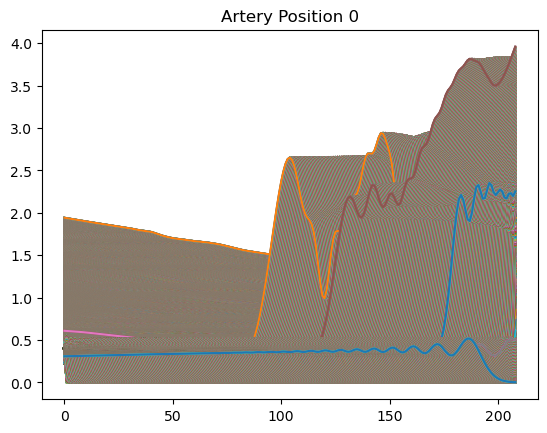

In [15]:
for r_min in []:
    try:
        an = ArteryNetwork(rho, nu, p0, ntr, Re, k, dataframe, Z_term, alpha, beta, r_min,)


        an.mesh(dx)
        an.set_time(dt, T, tc)
        an.initial_conditions(0, dataframe)

    


        # run solver
        an.solve(q_in, out_bc, out_args)
        tt.toc() 

        # redimensionalise
        an.redimensionalise(rc, qc)
        
        print('success!', r_min)
    except:
        print('NEXT!', r_min)
    



15 hrs

In [12]:
try:
    an.dump_results('VamPy_ST_r_min_0.025','C:\\Users\\cbnor\\Documents\\Full Body Flow Model Project')   
except:
     an.dump_results('VamPy_ST_r_min_0.025','C:\\Users\\Cassidy.Northway\\GitRemoteRepo')